# Particle Localization

We'll compare the performance of a dense neural network and of a convolutional neural network for the classification of blood smears in the Malaria dataset.

## Load Data

We'll load a dataset including two videos of optically trapped particles.

In [1]:
import os
import glob

if not os.path.exists("particle_dataset"):
    os.system("git clone -b cm https://github.com/DeepTrackAI/particle_dataset")

train_path = os.path.join("particle_dataset", "particle_dataset")
train_video_path = glob.glob(os.path.join(train_path, "*.avi"))

print(f"{len(train_video_path)} training videos")

2 training videos


In [2]:
import cv2
import numpy as np


def load_video(path, frames_to_load=100, image_size=51):
    video = cv2.VideoCapture(path)
    data = []
    for _ in range(frames_to_load):
        (_, frame) = video.read()
        frame = cv2.normalize(frame, None, 0, 255, cv2.NORM_MINMAX)
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) / 255
        frame = cv2.resize(frame, (image_size, image_size))
        data.append(frame)
    return np.array(data)

In [3]:
low_noise_data = load_video(train_video_path[1])
high_noise_data = load_video(train_video_path[0])

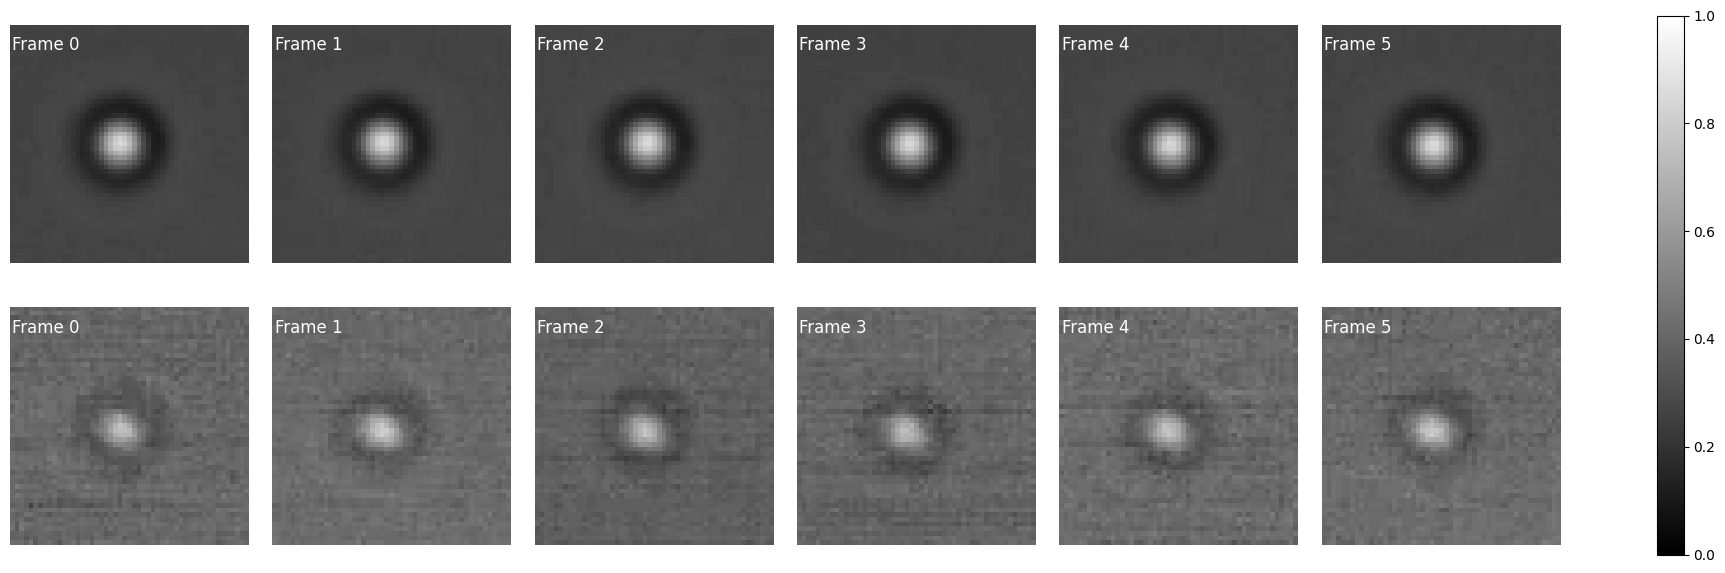

In [4]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(2, 6, figsize=(25, 7))
for i in range(6):
    im = ax[0, i].imshow(low_noise_data[i], vmin=0, vmax=1, cmap="gray")
    ax[0, i].text(0, 5, "Frame {}".format(i), color="white", fontsize=12)

    ax[0, i].axis("off")
    ax[1, i].imshow(high_noise_data[i], vmin=0, vmax=1, cmap="gray")
    ax[1, i].text(0, 5, "Frame {}".format(i), color="white", fontsize=12)
    ax[1, i].axis("off")
plt.subplots_adjust(wspace=0.1, hspace=0.1)
plt.colorbar(im, ax=ax.ravel().tolist())
plt.show()

In [5]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Cursor


class ParticleCenter:
    def __init__(self, images):
        self.images = images
        self.positions = []
        self.i = 0
        self.fig, self.ax = plt.subplots(1, 1, figsize=(5, 5))
        self.fig.canvas.header_visible = False
        self.fig.canvas.footer_visible = False

    def start(self):
        self.im = self.ax.imshow(self.images[self.i], cmap="gray", vmin=0, vmax=1)
        self.text = self.ax.text(
            3,
            5,
            "Frame " + str(self.i + 1) + " of " + str(len(self.images)),
            color="white",
            fontsize=12,
        )
        self.ax.axis("off")
        self.cursor = Cursor(self.ax, useblit=True, color="red", linewidth=1)
        self.cid = self.fig.canvas.mpl_connect("button_press_event", self.onclick)
        self.next_image()
        plt.show()

    def next_image(self):
        im = self.images[self.i]
        self.im.set_data(im)
        self.text.set_text("Frame " + str(self.i + 1) + " of " + str(len(self.images)))
        self.fig.canvas.draw_idle()

    def onclick(self, event):
        self.positions.append([event.xdata, event.ydata])
        if self.i < len(self.images) - 1:
            self.i += 1
            self.next_image()
        else:
            self.fig.canvas.mpl_disconnect(self.cid)
            plt.close()
            return

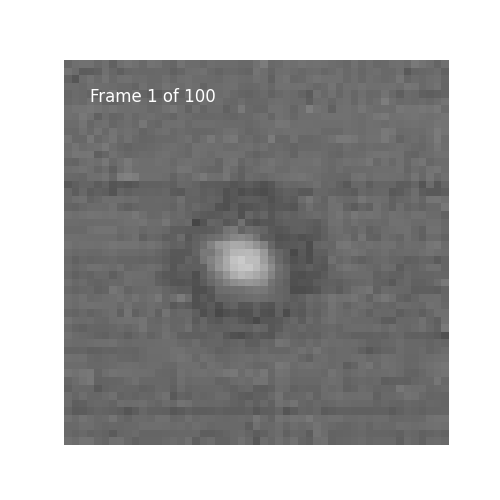

In [6]:
%matplotlib ipympl
from numpy.random import choice

number_of_images_to_annotate = 100

dataset = np.concatenate([low_noise_data, high_noise_data], axis=0)
np.random.shuffle(dataset)

images_to_annotate = choice(
  np.arange(dataset.shape[0]),
  number_of_images_to_annotate,
  replace=False
)

pc = ParticleCenter(dataset[images_to_annotate])
pc.start()

annotated_data = pc.images 
labels = pc.positions


In [24]:
np.save(
    os.path.join(train_path, "annotated_data.npy"),
    np.array(annotated_data),
)

np.save(
    os.path.join(train_path, "annotated_data_labels.npy"),
    np.array(labels),
)

In [32]:
from torch.utils.data import Dataset
import torch
import numpy as np


class ParticleDataset(Dataset):
    import torch
    import numpy as np

    def __init__(self, file, dir):
        self.im = np.load(os.path.join(dir, file))
        name, ext = os.path.splitext(file)
        self.pos = np.load(os.path.join(dir, name + "_labels" + ext))

    def __len__(self):
        return self.im.shape[0]

    def __getitem__(self, idx):
        img = torch.tensor(self.im[idx, np.newaxis, :, :]).float()
        labels = torch.tensor(self.pos[idx] / self.im.shape[1] - 0.5).float()
        sample = [img, labels]
        return sample

In [39]:
annotated_dataset = ParticleDataset("annotated_data.npy", train_path)
# train_dataloader = dl.DataLoader(train_dataset, batch_size=1)

In [44]:
from torch.utils.data import random_split

train_dataset, test_dataset = random_split(annotated_dataset, [0.8, 0.2])

train_dataloader = dl.DataLoader(train_dataset, batch_size=1)
test_dataloader = dl.DataLoader(test_dataset, batch_size=1)

In [45]:
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)

In [46]:
import deeplay as dl
import torch.nn

CNN = dl.Sequential(
    dl.ConvolutionalNeuralNetwork(
        in_channels=1,
        hidden_channels=[16, 32],
        out_channels=64,
        pool=torch.nn.MaxPool2d(
            kernel_size=2,
        ),
        out_activation=torch.nn.ReLU,
    ),
    dl.Layer(torch.nn.MaxPool2d, kernel_size=2),
    dl.Layer(Flatten),
    dl.MultiLayerPerceptron(
        in_features=6 * 6 * 64,
        hidden_features=[32, 32],
        out_features=2,
        out_activation=torch.nn.Identity,
    ),
)

print(CNN[0])

ConvolutionalNeuralNetwork(
  (blocks): LayerList(
    (0): PoolLayerActivationNormalization(
      (pool): Layer[Identity]()
      (layer): Layer[Conv2d](in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=64)
    )
    (1): PoolLayerActivationNormalization(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (layer): Layer[Conv2d](in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=64)
    )
    (2): PoolLayerActivationNormalization(
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (layer): Layer[Conv2d](in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
      (activation): Layer[ReLU]()
      (normalization): Layer[Identity](num_features=64)
    )
  )
)


In [47]:
import torchmetrics as tm

regressor = dl.Regressor(
    model=CNN,
    loss=torch.nn.MSELoss(),
    optimizer=dl.Adam(),
    metrics=[tm.MeanAbsoluteError()],
)

CNN_regressor = regressor.create()

We'll define the path to the directories containing the `Infected` and `Parasitized` images.

## Visualize Data

We'll then visualize some of the data.

## Data Preprocessing

We'll define a popeline to resize and normalize the data ...

In [48]:
CNN_trainer = dl.Trainer(
    max_epochs=50,  # How many times to run through the entire dataset
    accelerator="auto",  # Use GPU if available
)

CNN_trainer.fit(CNN_regressor, train_dataloader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.
2023-12-07 17:04:40.043201: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential     

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


In [142]:
test_results = CNN_trainer.test(CNN_regressor, test_dataloader)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        Test metric               DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
testMeanAbsoluteError_epoch    0.00370185449719429
      test_loss_epoch         2.512764694984071e-05
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Visualization of the predicted particle positions

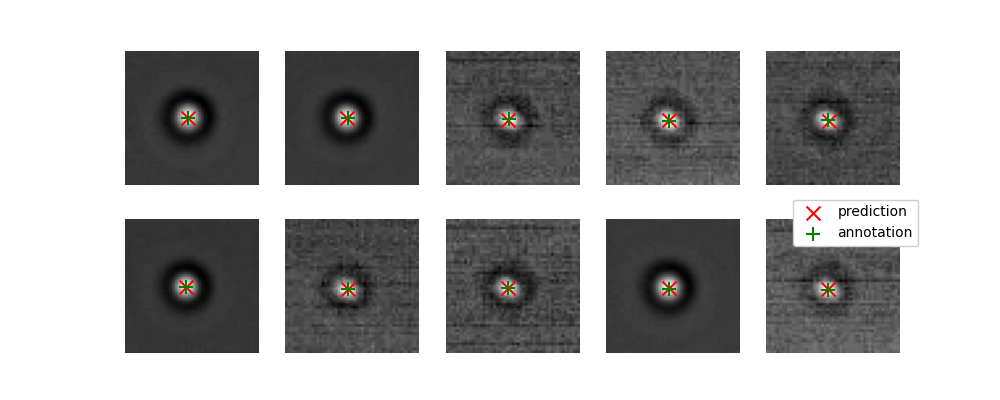

In [136]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.canvas.header_visible = False
fig.canvas.footer_visible = False

random_idx = np.random.choice(np.arange(len(test_dataset)), 10, replace=False)

for idx, ax in zip(random_idx, axes.flatten()):
    test_pred = CNN_regressor(test_dataset[idx][0].unsqueeze(0))[0].detach()
    IMAGE_SIZE = test_dataset[idx][0].shape[1]
    ax.imshow(test_dataset[idx][0].detach().numpy().squeeze(), cmap="gray")
    ax.scatter(
        test_pred[0] * IMAGE_SIZE + IMAGE_SIZE / 2,
        test_pred[1] * IMAGE_SIZE + IMAGE_SIZE / 2,
        marker="x",
        c="r",
        s=100,
        label="prediction",
    )
    ax.scatter(
        test_dataset[idx][1][0] * IMAGE_SIZE + IMAGE_SIZE / 2,
        test_dataset[idx][1][1] * IMAGE_SIZE + IMAGE_SIZE / 2,
        marker="+",
        c="g",
        s=100,
        label="annotation",
    )
    ax.set_axis_off()
ax.legend(loc=(0.2, 0.8), framealpha=1)

Test mean pixel error

In [159]:
print(
    "Mean pixel error: {:.3f} pixels".format(
        test_results[0]["testMeanAbsoluteError_epoch"] * IMAGE_SIZE
    )
)

# def mean_pixel_error(y_true, y_pred):
#     return np.mean(np.abs(np.array(y_true) - np.array(y_pred))) * IMAGE_SIZE


# test_lab, test_pred = [], []
# for td_im, td_lab in test_dataset:
#     test_pred.append(CNN_regressor(td_im.unsqueeze(0))[0].detach())
#     IMAGE_SIZE = test_dataset[idx][0].shape[1]
#     test_lab.append(td_lab)


# print("Mean pixel error: {:.3f} pixels".format(mean_pixel_error(test_lab, test_pred)))

Mean pixel error: 0.189 pixels


we will use the deeptrack library to simulate particle images and use these images to train our model.

In [160]:
from deeptrack.scatterers import MieSphere

particle = MieSphere(
    position=(25, 25),
    z=-5,
    radius=300e-9,
    refractive_index=1.37,
    position_unit="pixel",
)

/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/deeptrack/backend/_config.py:11: UserWarning: cupy not installed. GPU-accelerated simulations will not be possible
  warnings.warn(
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/deeptrack/backend/_config.py:25: UserWarning: cupy not installed, CPU acceleration not enabled
  warnings.warn("cupy not installed, CPU acceleration not enabled")
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issu

In [161]:
from deeptrack.optics import Brightfield

brightfield_microscope = Brightfield(
    wavelength=500e-9,
    NA=0.8,
    resolution=1e-6,
    magnification=15,
    refractive_index_medium=1.33,
    output_region=(0, 0, IMAGE_SIZE, IMAGE_SIZE),
)

In [162]:
imaged_particle = brightfield_microscope(particle)

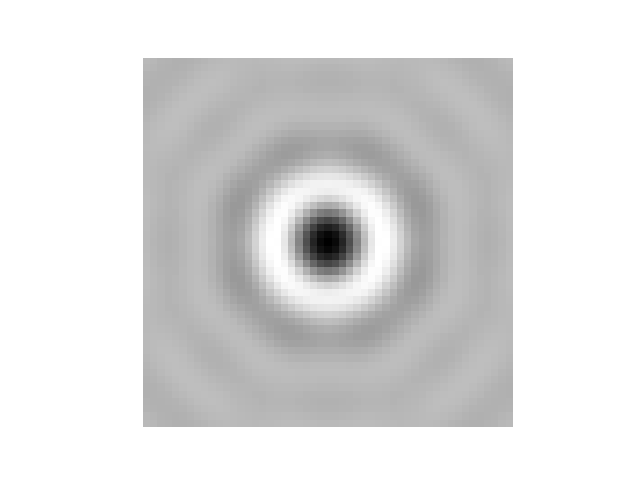

In [168]:
import matplotlib.pyplot as plt
from numpy import squeeze

fig = plt.figure()
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
output_image = imaged_particle.resolve()
plt.imshow(squeeze(output_image), cmap="gray")
plt.axis("off")
plt.show()

In [170]:
import numpy as np

particle = MieSphere(
    position=lambda: np.random.uniform(IMAGE_SIZE / 2 - 3, IMAGE_SIZE / 2 + 3, 2),
    z=lambda: np.random.uniform(-25, -5),
    radius=lambda: np.random.uniform(300e-9, 500e-9),
    refractive_index=lambda: np.random.uniform(1.37, 1.42),
    position_unit="pixel",
)
imaged_particle = brightfield_microscope(particle)

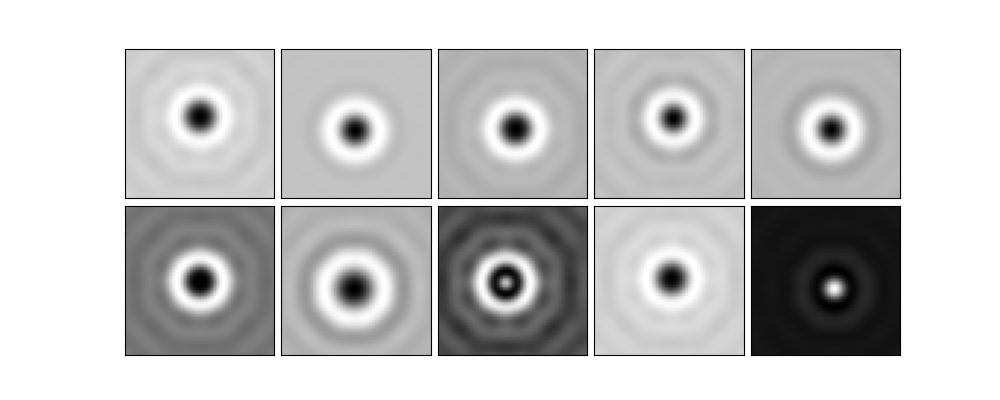

In [172]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
for i, ax in enumerate(axes.flatten()):
    output_image = imaged_particle.update().resolve()
    ax.imshow(squeeze(output_image), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [173]:
from deeptrack import Poisson

noise = Poisson(
    min_snr=5,
    max_snr=100,
    snr=lambda min_snr, max_snr: min_snr + np.random.rand() * (max_snr - min_snr),
    background=1,
)

noisy_imaged_particle = imaged_particle >> noise

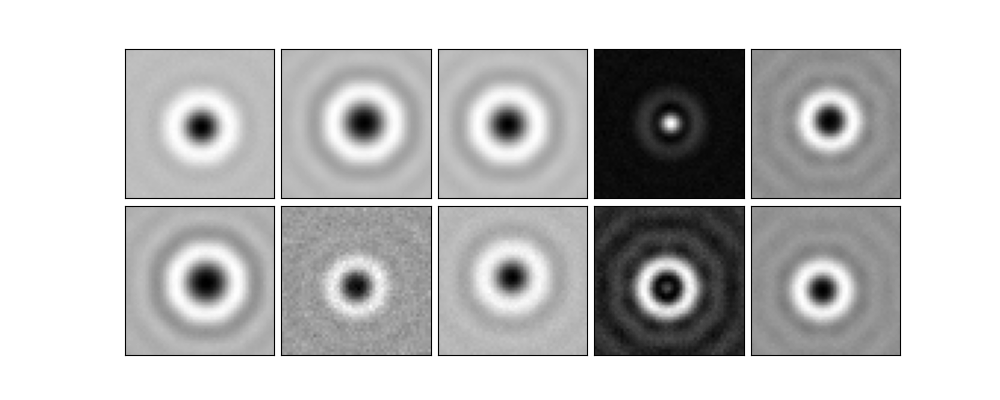

In [174]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
for i, ax in enumerate(axes.flatten()):
    output_image = noisy_imaged_particle.update().resolve()
    ax.imshow(squeeze(output_image), cmap="gray")
    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [175]:
from deeptrack import NormalizeMinMax

normalization = NormalizeMinMax(
    lambda: np.random.rand() * 0.2, lambda: 0.8 + np.random.rand() * 0.2
)
data_pipeline = noisy_imaged_particle >> normalization

In [176]:
def get_label(image):
    position = np.array(image.get_property("position")) / IMAGE_SIZE - 0.5
    return position

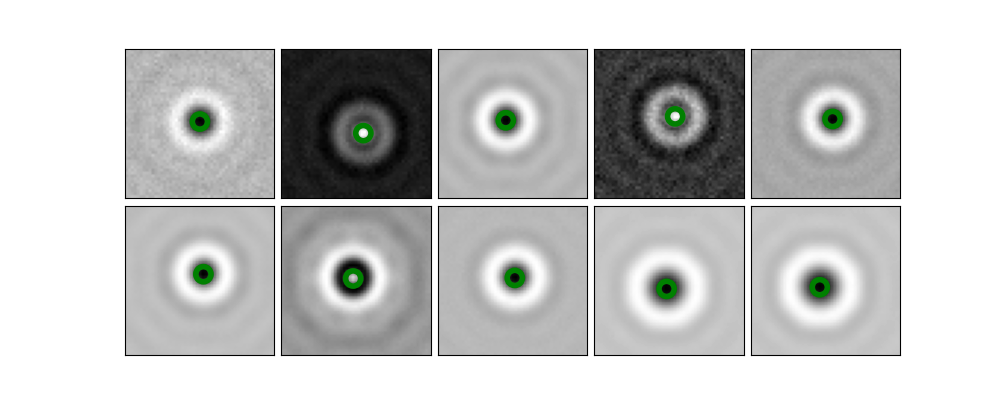

In [177]:
fig, axes = plt.subplots(2, 5, figsize=(10, 4))
fig.canvas.header_visible = False
fig.canvas.footer_visible = False
for i, ax in enumerate(axes.flatten()):
    output_image = data_pipeline.update().resolve()
    ax.imshow(squeeze(output_image), cmap="gray")

    particle_position = get_label(output_image) * IMAGE_SIZE + IMAGE_SIZE / 2
    ax.scatter(
        particle_position[1],
        particle_position[0],
        s=120,
        facecolors="none",
        edgecolor="g",
        linewidth=4,
    )

    ax.set_xticks([])
    ax.set_yticks([])
    plt.subplots_adjust(wspace=0.05, hspace=0.05)
plt.show()

In [179]:
from deeptrack.generators import ContinuousGenerator

generator = ContinuousGenerator(
    data_pipeline & (data_pipeline >> get_label),
    min_data_size=int(1e3),
    max_data_size=int(2e3),
    batch_size=32,
)

In [181]:
CNN_trainer = dl.Trainer(
    max_epochs=50,  # How many times to run through the entire dataset
    accelerator="auto",  # Use GPU if available
)

CNN_trainer.fit(CNN_regressor, generator)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/site-packages/lightning/pytorch/trainer/configuration_validator.py:74: You defined a `validation_step` but have no `val_dataloader`. Skipping val loop.

  | Name          | Type             | Params
---------------------------------------------------
0 | loss          | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | test_metrics  | MetricCollection | 0     
4 | model         | Sequential       | 98.2 K
5 | optimizer     | Adam             | 0     
---------------------------------------------------
98.2 K    Trainable params
0         Non-trainable params
98.2 K    Total params
0.393     Total estimated model params size (MB)
/Users/841602/Documents/GitHub/Environments/deeplay_env/lib/python3.10/si

Training: |          | 0/? [00:00<?, ?it/s]

AttributeError: 'ContinuousGenerator' object has no attribute 'current_data'

... subset the full dataset and split it into `train` and `test` sets ...

... and define the dataloaders for both sets. For the training, we'll set `batch_size = 32`.

## Fully-connected Neural Network

We'll define a Fully-connected Neural Network (FCNN) using `deeplay`. The FCNN has 2 layers with 128 features.

We'll define a classifier based on the FCNN architecture, including loss function, evaluation metrics and othe hyperparameters ...

... and a trainer including other hyperparameters ...

We'll start the training and visualize the evaluation metrics.

We'll calculate the performance over the test set.

## Convolutional Neural Network with a dense top
We'll now build a convolutional neural network (CNN) with a FCNN at the end ...


... define a classifier using the CNN ...

... train it ...

... evaluate the performance over the test set ...

... and display the ROC curve with the AUC value.

In [ ]:
images, gt, pred, _ = plot_ROC_AUC(classifier=CNN_classifier, dataset=test)

## Failure analysis
We'll use a function to visualize some of the wrongly classified cells, looking for common patterns.
```python
def plot_failure(images, gt, pred, threshold = 0.5, num_of_plots = 5):
    from matplotlib import pyplot as plt 
    from numpy import array, squeeze   
    
    pred = array(pred).squeeze()
    gt = array(gt).squeeze()
    images = array(images)

    pred_class = pred > threshold

    false_positives = (pred_class == 1) & (gt == 0)
    false_positives_images = images[false_positives]

    false_negatives = (pred_class == 0) & (gt == 1)
    false_negatives_images = images[false_negatives]

    plt.figure(figsize=(num_of_plots*2, 5))
    for i in range(num_of_plots):

        # false positives
        plt.subplot(2, num_of_plots, i + 1)
        plt.imshow(false_positives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False positives", fontsize=16, y=1.1)

        # false negatives
        plt.subplot(2, num_of_plots, i + num_of_plots + 1)
        plt.imshow(false_negatives_images[i].transpose(1, 2, 0))
        if i == 0:
            plt.title("False negatives", fontsize=16, y=1.1)

    plt.tight_layout()
    plt.show()
```

In [ ]:
from blood_smears import plot_failure

plot_failure(images=images, gt=gt, pred=pred, threshold=0.5, num_of_plots=4)

## Filters
We can access and visualize the filters used by the network at a specific layer.

In [ ]:
weights = CNN_classifier.model[0].input_block.layer.weight
w = weights.clone().detach()

from blood_smears import plot_filters_activations

plot_filters_activations(input=w, n_rows=4, label="Filters", normalize=True)

## Activations and Grad-CAM
To visualize the network feautures, we'll use `hooks`, functions that allows us to access the information that the model sees during forward and backward passes, such as activations and gradients, respectively. We'll define them as context manager classes, so that we can use them with the `with` statement:
```python
class fwd_hook():
    def __init__(self, m):
        self.hook = m.register_forward_hook(self.hook_func)   
    def hook_func(self, m, i, o):
        print('Forward hook running...') 
        self.stored = o.detach().clone()
        print(f'Activations size: {self.stored.size()}')
    def __enter__(self, *args): 
        return self
    def __exit__(self, *args): 
        self.hook.remove()

class bwd_hook():
    def __init__(self, m):
        self.hook = m.register_full_backward_hook(self.hook_func)
    def hook_func(self, m, gi, go):
        print('Backward hook running...')
        self.stored = go[0].detach().clone()
        print(f'Gradients size: {self.stored.size()}')
    def __enter__(self, *args): 
        return self
    def __exit__(self, *args): 
        self.hook.remove()
```

We'll randomly pick the image of an infected smear.

In [ ]:
import numpy as np
import matplotlib.image as mpimg

ind_infect = np.where((torch.cat(gt) == 1).tolist())[0]
ind = np.random.choice(ind_infect, 1)[0]

test_image = images[ind]
test_image_hr = mpimg.imread(dataset.imgs[subset.indices[test.indices[ind]]][0])

Activations and gradients at a specific layer can be obtained from the forward and backward pass, respectively ...

In [ ]:
from blood_smears import fwd_hook, bwd_hook

test_layer = CNN_classifier.model[0].blocks[3].layer

with bwd_hook(test_layer) as bh:
    with fwd_hook(test_layer) as fh:
        out = CNN_classifier.model(test_image.unsqueeze(0)).backward()
activations = fh.stored
gradients = bh.stored

... we can plot the activations ...

In [ ]:
plot_filters_activations(
    input=activations.permute(1, 0, 2, 3),
    n_rows=8,
    label="Feature maps",
    normalize=False,
)

... or combine gradients and activations to calculate Grad-CAM and inspect on which part of an image the CNN focuses on to predict its outputs. 

In [ ]:
pooled_grad = gradients[0].mean(dim=[1, 2], keepdim=True)
grad_cam = (
    torch.nn.functional.relu((pooled_grad * activations[0]).sum(0)).detach().numpy()
)

from blood_smears import plot_gradcam

plot_gradcam(grad_cam, test_image_hr)